## Install and import requisite modules
I used these modules to complete the challenge. 

- up42-py (UP42 Python SDK)
- numpy
- pandas
- rasterio
- geopandas
- matplotlib

Noted that the PDF requested just numpy, pandas, and rasterio but I wanted to clip to the AOI and make some visualizations so added geopandas and matplotlib for the ride, too.

In [ ]:
!pip install up42-py

In [2]:
#importing required libraries; have included matplotlib for plotting outputs, and os/pathlib for file management:
#I like to build a pyramid :)
import os
import up42
import pathlib
import rasterio
import numpy as np 
import pandas as pd
import geopandas as gpd
from rasterio.mask import mask
import matplotlib.pyplot as plt
from rasterio.enums import Resampling
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

# Housekeeping
Here I:
1. Imported the AOI data hyper-linked in the challenge PDF (_amazonas.geojson_);
2. Returned its extent information in order to query the UP42 catalogue for relevant S-2 scenes (later);
3. Approximated the AOI's UTM Zone, in order to determine a projected coordinate system;
4. Used the projected coordinate system to calculate the AOI area in nice SI units, in order to have a better sense of project scale, and make decisions accordingly.

I determined _amazonas.geojson_ to be an easy enough area to work (793 km^2) with and decided to not further reduce its size.


In [3]:
#set path relative to root of repo to AOI geoJSON. 
#If you're downloading this repo, you'll need to keep the entire dir in the same structure.
root = os.getcwd()
path = pathlib.Path(root, "data/amazonas.geojson")

#read in the Amazonas AOI and get the bounds:
aoi = gpd.read_file(path)
bounds = aoi.total_bounds.tolist()
print("Bottom left and top right coords, respectively:", bounds)

#estimate the UTM zone
long = bounds[0] + 180 #longitude
zone = np.round(long/6,0) #longitude zone
print("UTM zone is ~", zone, "which corresponds to EPSG code 32521") #looked up the EPSG code for UTM 21S

#Find area of original AOI:
copy = aoi.copy()
copy.head()
copy = copy.to_crs({'init': 'epsg:32521'}) #re-projecting to UTM 21S so we can calculate in metres.
copy.crs
copy["area"] = copy['geometry'].area/ 10**6 #square metres to square km conversion. 

#The AOI is not so large that it requires an equal area projection. 
#We will stick with the estimated based on UTM Zone 21S. 
print("Project area is", round(copy["area"].values[0],1), "km^2")

Bottom left and top right coords, respectively: [-55.80602463366668, -13.49938970772358, -55.520612343249226, -13.267580954511516]
UTM zone is ~ 21.0 which corresponds to EPSG code 32521
Project area is 792.6 km^2


# Initialize the UP42 SDK

I removed my temporary credentials from here operating on the assumption I shouldn't leave these in a public repo, and that the reviewers can simply input their own.

If needed I am happy to supply the temp credentials however UP42 sees fit!

In [4]:
#authenticate with UP42:
up42.authenticate(
    username="challenge+jessesmith@up42.com",
    password="4C,%>GiWY9I3",
)

2023-12-07 02:03:43,598 - Authentication with UP42 successful!


# Get Sentinel-2 data products from UP42 catalog
Below I: <br>
- Returned a catalogue with all collections types;
- Selected ID corresponding to level 2-A assets, which are surface reflectance pixel values.
- This is important because surface reflectance image pixel are standardized to % of light reflected from below the atmosphere, so the data is uncontaminated by atmospheric effects (except for cloud), and aesthetic image enhancements.
- This makes it possible to combine time series analyses across a mix of sensors (e.g. LANDSAT series);
- This is important if Green Park Gmbh wishes to go back _prior_ to June 2015, when Sentinel-2 became operational, and continue their time series analyses with additional sensors (such as the LANDSAT series).

In [5]:
catalog = up42.initialize_catalog()
data_products = catalog.get_data_products(basic=True) #all data products
data_product_id = catalog.get_data_products(basic=True).get("Sentinel-2").get("data_products").get("Level-2A") #S-2 L2A

## Re: concerns about data availability 

I noted that Green Park Gmbh is concerned by the potential for data paucity of Sentinel 2 over their AOI. 

Below, I ran a loop that aggregated the number of images available throughout the years, with different cloud cover percentages. Then below, the results are visualized in a bar chart. This is to show they have quite a bit of options, annually, with low cloud cover obstruction.

- Search results in the block above show that there are 169 images of their AOI between S2's launch and the date at the time of writing
- The client should be relieved to know there is quite a bit of data availability from the last ten years
- There's 169 scenes with <= 5% cloud cover.
- This raises to 264 when maximum cloud cover is increased to 25%
- Below is a plot showing image availability with increased maximum cloud coverage (x-axis). The number of images per year is expressed in the colour blocks within each bar.
- Hopefully this concern is assuaged!

In [6]:
results = []
cloudcover = []
year = []

for i in range(1,26):
    search_results = catalog.search(search_parameters=catalog.construct_search_parameters(
        geometry= bounds,
        start_date="2015-06-24", 
        end_date="2023-12-05",
        collections=[data_products.get("Sentinel-2").get("collection")],
        max_cloudcover=i, 
        limit=300))

    search_copy = search_results.copy()
    search_copy["year"] = search_copy["acquisitionDate"].str[:4]
        
    for annum in range(2017,2024):
        results.append(len(search_copy[search_copy["year"] == str(annum)]))
        cloudcover.append(i)    
        year.append(annum)

2023-12-07 02:03:52,858 - Searching catalog with search_parameters: {'datetime': '2015-06-24T00:00:00Z/2023-12-05T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((-55.520612343249226, -13.49938970772358), (-55.520612343249226, -13.267580954511516), (-55.80602463366668, -13.267580954511516), (-55.80602463366668, -13.49938970772358), (-55.520612343249226, -13.49938970772358)),)}, 'limit': 300, 'collections': ['sentinel-2'], 'query': {'cloudCoverage': {'lte': 1}}}
2023-12-07 02:03:57,139 - 97 results returned.
2023-12-07 02:03:57,170 - Searching catalog with search_parameters: {'datetime': '2015-06-24T00:00:00Z/2023-12-05T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((-55.520612343249226, -13.49938970772358), (-55.520612343249226, -13.267580954511516), (-55.80602463366668, -13.267580954511516), (-55.80602463366668, -13.49938970772358), (-55.520612343249226, -13.49938970772358)),)}, 'limit': 300, 'collections': ['sentinel-2'], 'query': {'cloudCoverage': {'lt

## Data visualizations
- These show that there are actually quite a few options for Green Plant Gmbh for free imagery over their AOI.
- They also reveal that some years are better than others for data. e.g. 2019 was a very cloudy year for Matto Gross state, Brazil!

In [7]:
#make a pivot table, e.g. wide format for plotting:
df = pd.DataFrame(list(zip(cloudcover, year, results)), columns =['cloudcover', 'year', 'results'])
dfp = df.pivot_table(index='cloudcover', columns='year', values='results')

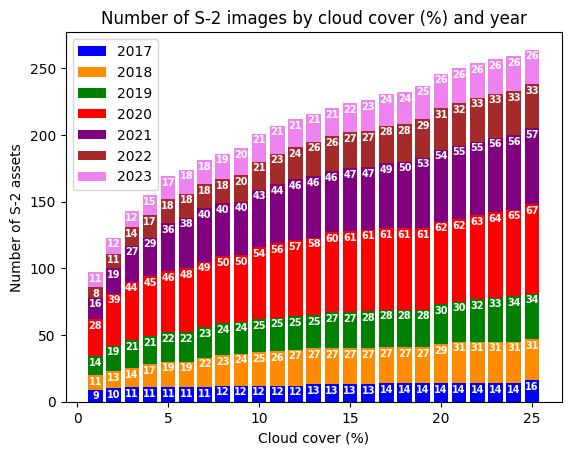

In [8]:
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots()

colors = ["blue", "darkorange", "green", "red", "purple", "brown", "violet"]
bottom = np.zeros(len(dfp))

for i, col in enumerate(dfp.columns):
  ax.bar(
      dfp.index, dfp[col], bottom=bottom, label=col, color=colors[i])
  bottom += np.array(dfp[col])

totals = dfp.sum(axis=1)
#y_offset = 4
y_offset = -7

for bar in ax.patches:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + bar.get_y() + y_offset,
      round(bar.get_height()),
      ha='center',
      color='w',
      weight = 'bold',
      size=7
  )

ax.set_title('Number of S-2 images by cloud cover (%) and year')
ax.set_ylabel('Number of S-2 assets')
ax.set_xlabel('Cloud cover (%)')
ax.legend()
plt.show()

In [9]:
#Sticking with the 5% cloud cover for the rest of the analysis:

search_results = catalog.search(search_parameters=catalog.construct_search_parameters(
    geometry= bounds,
    start_date="2015-06-24", 
    end_date="2023-12-05",
    collections=[data_products.get("Sentinel-2").get("collection")],
    max_cloudcover=5, 
    limit=300))
len(search_results)

2023-12-07 02:06:30,051 - Searching catalog with search_parameters: {'datetime': '2015-06-24T00:00:00Z/2023-12-05T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((-55.520612343249226, -13.49938970772358), (-55.520612343249226, -13.267580954511516), (-55.80602463366668, -13.267580954511516), (-55.80602463366668, -13.49938970772358), (-55.520612343249226, -13.49938970772358)),)}, 'limit': 300, 'collections': ['sentinel-2'], 'query': {'cloudCoverage': {'lte': 5}}}
2023-12-07 02:06:34,617 - 169 results returned.


169

### Filtering 

A number of good quality S-2 images are now available in `search_results`. However, some extra considerations should be taken about how and when to measure NDVI.

To get a good NDVI result, I implemented some extra conditions:
1. The AOI is in the Brazilian state of Matto Grosso, which is in the tropics, and experiences a dry-wet seasons.
2. Vegetation is most likely at its strongest and densest immediately following the wet season.
3. Measuring NDVI at the end of the wet season should give a good idea of the realistic area and extent of vegetation, since there is less risk of certain plants shedding foliage, or not reflecting enough nIR seasonally.
3. Therefore, I selected the should of month leading into the dry season: May, and further filtered the results for only images in this month.
4. I selected one random scene in May for each year of data availability (2017-2023).

In [10]:
subset = search_results[search_results['acquisitionDate'].str.contains('-05-')] #subset to May acquisitions
sub = subset.copy()
sub['year'] = subset['acquisitionDate'].str[:4]
subset = subset.loc[sub.groupby('year').sample(1, random_state=1).index.values.tolist()] #random date selection

,geometry,id,constellation,collection,providerName,up42:usageType,providerProperties,sceneId,producer,acquisitionDate,start_datetime,end_datetime,cloudCoverage,resolution,deliveryTime
167,"POLYGON ((-56.07910 -12.66242, -55.06828 -12.6...",S2A_21LXF_20170507_0_L2A,sentinel-2,sentinel-2,earthsearch-aws,[DATA],"{'s2:degraded_msi_data_percentage': 0, 's2:dat...",S2A_21LXF_20170507_0_L2A,european-space-agency,2017-05-07T14:00:55.458Z,None,None,0.118191,10.0,MINUTES
154,"POLYGON ((-56.07910 -12.66242, -55.06828 -12.6...",S2A_21LXF_20180502_0_L2A,sentinel-2,sentinel-2,earthsearch-aws,[DATA],"{'s2:degraded_msi_data_percentage': 0, 's2:dat...",S2A_21LXF_20180502_0_L2A,european-space-agency,2018-05-02T14:00:54.461Z,None,None,0.010561,10.0,MINUTES
136,"POLYGON ((-56.07910 -12.66242, -55.06828 -12.6...",S2A_21LXF_20190527_0_L2A,sentinel-2,sentinel-2,earthsearch-aws,[DATA],"{'s2:degraded_msi_data_percentage': 0, 's2:dat...",S2A_21LXF_20190527_0_L2A,european-space-agency,2019-05-27T14:06:14.197Z,None,None,4.462749,10.0,MINUTES
113,"POLYGON ((-56.07910 -12.66242, -56.07538 -13.6...",S2B_21LXF_20200526_1_L2A,sentinel-2,sentinel-2,earthsearch-aws,[DATA],"{'s2:degraded_msi_data_percentage': 0.0093, 's...",S2B_21LXF_20200526_1_L2A,european-space-agency,2020-05-26T14:06:12.254Z,None,None,1.191678,10.0,MINUTES
64,"POLYGON ((-56.07910 -12.66242, -56.07538 -13.6...",S2B_21LXF_20210501_1_L2A,sentinel-2,sentinel-2,earthsearch-aws,[DATA],"{'s2:degraded_msi_data_percentage': 0.009, 's2...",S2B_21LXF_20210501_1_L2A,european-space-agency,2021-05-01T14:06:07.417Z,None,None,4.596199,10.0,MINUTES
33,"POLYGON ((-56.07910 -12.66242, -55.06828 -12.6...",S2A_21LXF_20220501_0_L2A,sentinel-2,sentinel-2,earthsearch-aws,[DATA],"{'s2:degraded_msi_data_percentage': 0.0197, 's...",S2A_21LXF_20220501_0_L2A,european-space-agency,2022-05-01T14:06:16.318Z,None,None,0.098125,10.0,MINUTES
15,"POLYGON ((-56.07910 -12.66242, -55.06828 -12.6...",S2A_21LXF_20230516_0_L2A,sentinel-2,sentinel-2,earthsearch-aws,[DATA],"{'s2:degraded_msi_data_percentage': 0.0201, 's...",S2A_21LXF_20230516_0_L2A,european-space-agency,2023-05-16T14:06:12.401Z,None,None,0.001264,10.0,MINUTES


### Placing the subsetted order.

Here I looped through each image in the the search results, placing an order for each one. This took ~ 45 minutes to complete. 

Note the need to accept the EULA (End User License Agreement) for the data source first, otherwise you will receive an error.<br>
This can be done at https://console.up42.com/settings/

In [11]:
ids = subset.id.tolist()
orders = []
images_ids = []

for idx, id in enumerate(ids):
    order_parameters = catalog.construct_order_parameters(
        data_product_id=data_product_id, image_id=subset.id.iloc[idx])
    catalog.estimate_order(order_parameters)
    order = catalog.place_order(order_parameters, track_status=True)
    orders.append(order)
    images_ids.append(order_parameters['params']['id'])

2023-12-07 02:07:38,594 - See `catalog.get_data_product_schema(data_product_id)` for more detail on the parameter options.
2023-12-07 02:07:42,268 - Order is estimated to cost 0 UP42 credits (order_parameters: {'dataProduct': 'c3de9ed8-f6e5-4bb5-a157-f6430ba756da', 'params': {'id': 'S2A_21LXF_20170507_0_L2A'}})
2023-12-07 02:07:45,243 - Order is PLACED
2023-12-07 02:07:45,245 - Order 28e00c69-50be-4541-b4c5-a562bfe1333c is now PLACED.
2023-12-07 02:07:45,246 - Tracking order status, reporting every 120 seconds...
2023-12-07 02:07:45,504 - Order is PLACED
2023-12-07 02:07:45,716 - Order is PLACED
2023-12-07 02:09:47,158 - Order is BEING_FULFILLED
2023-12-07 02:09:47,382 - Order is BEING_FULFILLED
2023-12-07 02:09:47,603 - Order is BEING_FULFILLED! - 28e00c69-50be-4541-b4c5-a562bfe1333c
2023-12-07 02:09:47,604 - 
2023-12-07 02:11:47,856 - Order is BEING_FULFILLED
2023-12-07 02:11:48,108 - Order is BEING_FULFILLED
2023-12-07 02:11:48,327 - Order is BEING_FULFILLED! - 28e00c69-50be-4541-b4

# Downloading STAC assets

Once the order was fulfilled, I chose to again iterate through each order and take a STAC asset of interest. 

In this application, I was interested in the 4th, 8th, and _SCL_ assets, as these corrspond to the red, near infrared (abbreviated from here forwards as _nIR_), and image classification bands. The first two are needed to calculate NDVI, while the lattermost allows for the construction of a mask to remove cloud cover and the shadows they cast from the images, which will skew NDVI values down as they cover vegetation and other objects on the ground.

These data were output to the _/data_ folder and into a sub-folder with the name of the S-2 scene the assets belong to. The GeoTIFF images themselves retain the simple band numbers or names they correspond to.

In [13]:
bands = ["b04.tiff", "b08.tiff", "scl.tiff"] #4 is red, 8 is NIR, and scl is land class in S-2 products
for i in range(0, len(orders)):
    asset = up42.initialize_order(order_id=orders[i].order_id).get_assets()[0]
    stac_items = asset.stac_items
    stac_assets = stac_items[0].assets
    for band in bands:
        print("Downloading", band, "band...")
        asset.download_stac_asset(
        stac_asset=stac_assets.get(band),
        output_directory=pathlib.Path(root, "data/", ids[i]),
    )

2023-12-07 02:51:14,582 - Initialized Order(order_id: 28e00c69-50be-4541-b4c5-a562bfe1333c, assets: ['50cf88f3-7e10-49d0-918b-b7a425565571'], dataProvider: None, status: FULFILLED, createdAt: 2023-12-07T02:07:43.246904Z, updatedAt: 2023-12-07T02:12:48.344514Z)
2023-12-07 02:51:14,792 - Order is FULFILLED
2023-12-07 02:51:16,861 - Downloading STAC asset Red (band 4) - 10m
2023-12-07 02:51:16,862 - Download directory: /Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20170507_0_L2A


193726it [00:37, 5224.87it/s]
2023-12-07 02:51:54,688 - Successfully downloaded the file at /Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20170507_0_L2A/b04.tiff
2023-12-07 02:51:54,697 - Downloading STAC asset NIR 1 (band 8) - 10m
2023-12-07 02:51:54,701 - Download directory: /Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20170507_0_L2A


223084it [00:45, 4943.86it/s]
2023-12-07 02:52:40,303 - Successfully downloaded the file at /Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20170507_0_L2A/b08.tiff
2023-12-07 02:52:40,309 - Downloading STAC asset Scene classification map (SCL)
2023-12-07 02:52:40,312 - Download directory: /Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20170507_0_L2A


650it [00:00, 1623.84it/s]
2023-12-07 02:52:41,336 - Successfully downloaded the file at /Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20170507_0_L2A/scl.tiff
2023-12-07 02:52:41,682 - Initialized Order(order_id: 83503673-8d94-4a87-9cba-4ffc8306a37a, assets: ['73b5a7b9-fbd8-402e-a5b1-2d20e0d64d89'], dataProvider: None, status: FULFILLED, createdAt: 2023-12-07T02:13:53.344056Z, updatedAt: 2023-12-07T02:18:45.974867Z)
2023-12-07 02:52:41,982 - Order is FULFILLED
2023-12-07 02:52:44,955 - Downloading STAC asset Red (band 4) - 10m
2023-12-07 02:52:44,957 - Download directory: /Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20180502_0_L2A


190327it [00:53, 3556.94it/s]
2023-12-07 02:53:39,173 - Successfully downloaded the file at /Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20180502_0_L2A/b04.tiff
2023-12-07 02:53:39,180 - Downloading STAC asset NIR 1 (band 8) - 10m
2023-12-07 02:53:39,182 - Download directory: /Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20180502_0_L2A


223193it [00:56, 3961.01it/s]
2023-12-07 02:54:36,111 - Successfully downloaded the file at /Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20180502_0_L2A/b08.tiff
2023-12-07 02:54:36,115 - Downloading STAC asset Scene classification map (SCL)
2023-12-07 02:54:36,117 - Download directory: /Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20180502_0_L2A


552it [00:00, 3159.67it/s]
2023-12-07 02:54:36,780 - Successfully downloaded the file at /Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20180502_0_L2A/scl.tiff
2023-12-07 02:54:37,057 - Initialized Order(order_id: 56506ed0-f90d-42c5-a821-1740e664747c, assets: ['2c0e2c9f-cae7-430a-af9c-cee315e38c01'], dataProvider: None, status: FULFILLED, createdAt: 2023-12-07T02:20:03.502434Z, updatedAt: 2023-12-07T02:24:59.468281Z)
2023-12-07 02:54:37,384 - Order is FULFILLED
2023-12-07 02:54:39,385 - Downloading STAC asset Red (band 4) - 10m
2023-12-07 02:54:39,387 - Download directory: /Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20190527_0_L2A


213888it [00:47, 4536.04it/s]
2023-12-07 02:55:27,072 - Successfully downloaded the file at /Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20190527_0_L2A/b04.tiff
2023-12-07 02:55:27,081 - Downloading STAC asset NIR 1 (band 8) - 10m
2023-12-07 02:55:27,082 - Download directory: /Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20190527_0_L2A


232766it [00:48, 4828.49it/s]
2023-12-07 02:56:15,858 - Successfully downloaded the file at /Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20190527_0_L2A/b08.tiff
2023-12-07 02:56:15,865 - Downloading STAC asset Scene classification map (SCL)
2023-12-07 02:56:15,868 - Download directory: /Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20190527_0_L2A


2366it [00:00, 4219.53it/s]
2023-12-07 02:56:16,960 - Successfully downloaded the file at /Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20190527_0_L2A/scl.tiff
2023-12-07 02:56:17,257 - Initialized Order(order_id: f890665d-859a-45a8-bfcf-c02f3cda02eb, assets: ['8d5c16e2-ac1e-4ce5-8780-5fe0ac383906'], dataProvider: None, status: FULFILLED, createdAt: 2023-12-07T02:26:13.624392Z, updatedAt: 2023-12-07T02:30:38.794693Z)
2023-12-07 02:56:17,551 - Order is FULFILLED
2023-12-07 02:56:19,880 - Downloading STAC asset Red (band 4) - 10m
2023-12-07 02:56:19,883 - Download directory: /Users/jsmith/Desktop/Challenge/data/S2B_21LXF_20200526_1_L2A


198664it [00:41, 4753.25it/s]
2023-12-07 02:57:02,168 - Successfully downloaded the file at /Users/jsmith/Desktop/Challenge/data/S2B_21LXF_20200526_1_L2A/b04.tiff
2023-12-07 02:57:02,177 - Downloading STAC asset NIR 1 (band 8) - 10m
2023-12-07 02:57:02,194 - Download directory: /Users/jsmith/Desktop/Challenge/data/S2B_21LXF_20200526_1_L2A


222855it [00:45, 4862.22it/s]
2023-12-07 02:57:48,724 - Successfully downloaded the file at /Users/jsmith/Desktop/Challenge/data/S2B_21LXF_20200526_1_L2A/b08.tiff
2023-12-07 02:57:48,734 - Downloading STAC asset Scene classification map (SCL)
2023-12-07 02:57:48,738 - Download directory: /Users/jsmith/Desktop/Challenge/data/S2B_21LXF_20200526_1_L2A


1210it [00:00, 4383.74it/s]
2023-12-07 02:57:49,532 - Successfully downloaded the file at /Users/jsmith/Desktop/Challenge/data/S2B_21LXF_20200526_1_L2A/scl.tiff
2023-12-07 02:57:49,813 - Initialized Order(order_id: 9218c7a0-cfe6-418b-a151-69de29acd5d5, assets: ['88830c64-5dda-47b0-b82f-692969a13051'], dataProvider: None, status: FULFILLED, createdAt: 2023-12-07T02:32:22.524890Z, updatedAt: 2023-12-07T02:37:05.063273Z)
2023-12-07 02:57:49,996 - Order is FULFILLED
2023-12-07 02:57:52,264 - Downloading STAC asset Red (band 4) - 10m
2023-12-07 02:57:52,265 - Download directory: /Users/jsmith/Desktop/Challenge/data/S2B_21LXF_20210501_1_L2A


205457it [00:41, 4960.19it/s]
2023-12-07 02:58:34,186 - Successfully downloaded the file at /Users/jsmith/Desktop/Challenge/data/S2B_21LXF_20210501_1_L2A/b04.tiff
2023-12-07 02:58:34,194 - Downloading STAC asset NIR 1 (band 8) - 10m
2023-12-07 02:58:34,197 - Download directory: /Users/jsmith/Desktop/Challenge/data/S2B_21LXF_20210501_1_L2A


226234it [00:42, 5266.74it/s]
2023-12-07 02:59:17,823 - Successfully downloaded the file at /Users/jsmith/Desktop/Challenge/data/S2B_21LXF_20210501_1_L2A/b08.tiff
2023-12-07 02:59:17,829 - Downloading STAC asset Scene classification map (SCL)
2023-12-07 02:59:17,831 - Download directory: /Users/jsmith/Desktop/Challenge/data/S2B_21LXF_20210501_1_L2A


1533it [00:00, 3009.51it/s]
2023-12-07 02:59:18,877 - Successfully downloaded the file at /Users/jsmith/Desktop/Challenge/data/S2B_21LXF_20210501_1_L2A/scl.tiff
2023-12-07 02:59:19,140 - Initialized Order(order_id: 4de6de50-6245-4c7f-81b3-f7ff9040bf66, assets: ['c6c05d88-04d3-4457-84b0-235bd8f831af'], dataProvider: None, status: FULFILLED, createdAt: 2023-12-07T02:38:33.992058Z, updatedAt: 2023-12-07T02:43:43.114815Z)
2023-12-07 02:59:19,363 - Order is FULFILLED
2023-12-07 02:59:21,484 - Downloading STAC asset Red (band 4) - 10m
2023-12-07 02:59:21,487 - Download directory: /Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20220501_0_L2A


190162it [00:36, 5236.20it/s]
2023-12-07 02:59:58,376 - Successfully downloaded the file at /Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20220501_0_L2A/b04.tiff
2023-12-07 02:59:58,383 - Downloading STAC asset NIR 1 (band 8) - 10m
2023-12-07 02:59:58,385 - Download directory: /Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20220501_0_L2A


217119it [00:38, 5598.01it/s]
2023-12-07 03:00:37,721 - Successfully downloaded the file at /Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20220501_0_L2A/b08.tiff
2023-12-07 03:00:37,729 - Downloading STAC asset Scene classification map (SCL)
2023-12-07 03:00:37,730 - Download directory: /Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20220501_0_L2A


660it [00:00, 3700.11it/s]
2023-12-07 03:00:38,406 - Successfully downloaded the file at /Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20220501_0_L2A/scl.tiff
2023-12-07 03:00:38,629 - Initialized Order(order_id: 0f97a47b-840f-43c4-b6e6-f8bdec242ad2, assets: ['e2cb6c7a-074c-4db8-bd70-b0468c1a7d7d'], dataProvider: None, status: FULFILLED, createdAt: 2023-12-07T02:44:43.767593Z, updatedAt: 2023-12-07T02:49:36.170579Z)
2023-12-07 03:00:38,849 - Order is FULFILLED
2023-12-07 03:00:41,029 - Downloading STAC asset Red (band 4) - 10m
2023-12-07 03:00:41,031 - Download directory: /Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20230516_0_L2A


191134it [00:38, 4962.78it/s]
2023-12-07 03:01:20,091 - Successfully downloaded the file at /Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20230516_0_L2A/b04.tiff
2023-12-07 03:01:20,096 - Downloading STAC asset NIR 1 (band 8) - 10m
2023-12-07 03:01:20,101 - Download directory: /Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20230516_0_L2A


219677it [00:40, 5364.58it/s]
2023-12-07 03:02:01,597 - Successfully downloaded the file at /Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20230516_0_L2A/b08.tiff
2023-12-07 03:02:01,603 - Downloading STAC asset Scene classification map (SCL)
2023-12-07 03:02:01,606 - Download directory: /Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20230516_0_L2A


706it [00:00, 3142.36it/s]
2023-12-07 03:02:02,289 - Successfully downloaded the file at /Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20230516_0_L2A/scl.tiff


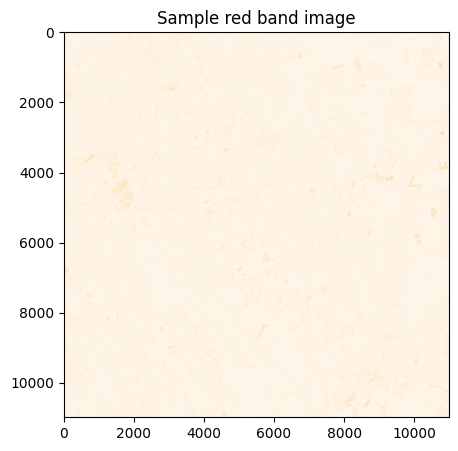

In [14]:
with rasterio.open(pathlib.Path(root, "data/", ids[6], "b04.tiff")) as src:
    red1 = src.read(1)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title("Sample red band image")
    im = ax.imshow(red1, cmap='OrRd')

# Pre-processing the images and calculating NDVI

Referring to [Sentinel-2 documentation](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/processing-levels/level-2#:~:text=20%20m%3A%20containing%20spectral%20bands,provides%20more%20precise%20spectral%20information.), the SCL asset/band is one of few with a 20 m spatial resolution, which does not accord well with red and nIR being in 10 m, especially when interacting in numpy. This needed to be resampled to follow the array dimensions of the red and nIR bands.

Then, iteratively, I :
1. Read in each band into memory as numpy array;
2. Clipped the scene to the AOI extent (_amazonas.geojson_);
3. Calculated NDVI as: NIR - RED / NIR + RED;
4. Recorded summary statistics of NDVI (mean, max, min);
5. Wrote the result array out to a GeoTIFF.


In [15]:
#scl band is in 20m resolution, so we will resample to 10m to match the other bands:

def resample_raster(src, match):
    with rasterio.open(src) as src:
        with rasterio.open(match) as match:
            data = src.read(
                out_shape=(
                    src.count,
                    match.height,
                    match.width
                ),
                resampling=Resampling.bilinear
            )
            kwargs = src.meta.copy()
            kwargs.update({
                'height': match.height,
                'width': match.width,
                'transform': match.transform
            })
            with rasterio.open(src.name, 'w', **kwargs) as dst:
                dst.write(data)



In [16]:
# loop to clip images and calculate NDVI, record simple statistics. 

means = []
mins = []
maxs = []

for id in ids:
    
    print(id)

    resample_raster(pathlib.Path(root, "data/", id, "scl.tiff"), pathlib.Path(root, "data/", ids[0], "b08.tiff"))

    with rasterio.open(pathlib.Path(root, 'data', id, "b04.tiff"), 'r+') as ds1:
        out_red, out_red_transform=mask(ds1,copy.geometry,crop=True, nodata=9999)
    with rasterio.open(pathlib.Path(root,'data', id, "b08.tiff"), 'r+') as ds2:
        out_nir, out_nir_transform=mask(ds2,copy.geometry,crop=True, nodata=9999)
    with rasterio.open(pathlib.Path(root,'data', id, "scl.tiff"), 'r+') as ds3:
        out_scl, out_scl_transform=mask(ds3,copy.geometry,crop=True, nodata=9999)
    
        maskby = np.where((out_scl == 3) | (out_scl == 8) | (out_scl == 9) | (out_scl == 10), 0, 1)
        maskby = maskby.astype('float')
        maskby[maskby == 0] = 'nan'
        mask_red = out_red * maskby
        mask_nir = out_nir * maskby

    ndvi = np.zeros(mask_red.shape, dtype=rasterio.float32)
    ndvi = (mask_nir.astype(float)-mask_red.astype(float))/(mask_nir+mask_red)

    print("NDVI mean:", np.nanmean(ndvi))
    means.append(np.nanmean(ndvi))
    mins.append(np.nanmin(ndvi))
    maxs.append(np.nanmax(ndvi))

    out_meta=ds1.meta.copy() # copy the metadata of the source DEM
    out_meta.update({
        "driver":"Gtiff",
        "dtype":rasterio.float32,
        "height":mask_red.shape[1], # height starts with shape[1]
        "width":mask_red.shape[2], # width starts with shape[2]
        "transform":out_red_transform,
        "nodata":9999
    })

    with rasterio.open(pathlib.Path(root,'data', id, "ndvi.tiff"), 'w', **out_meta) as dst:
        dst.write(ndvi.astype(rasterio.float32))
print("done")



S2A_21LXF_20170507_0_L2A
NDVI mean: 0.7852468657797603
S2A_21LXF_20180502_0_L2A
NDVI mean: 0.79503672811489
S2A_21LXF_20190527_0_L2A
NDVI mean: 0.6634377388672453
S2B_21LXF_20200526_1_L2A
NDVI mean: 0.7162995927957309
S2B_21LXF_20210501_1_L2A
NDVI mean: 0.7484214395883277
S2A_21LXF_20220501_0_L2A
NDVI mean: 0.7683179060742995
S2A_21LXF_20230516_0_L2A
NDVI mean: 0.7938851851718615
done


# Data visualizations

Below is:

1. A typical NDVI output raster;
2. A plot showing mean, max, and min NDVI over each May;
3. The NDVI difference between the first year (2017), and the most recent year (2023);
4. A pair of histograms suggesting some shift in higher NDVI values. 
5. A reclassified raster map, showing the area with a net positive increase in NDVI, and the area it occupies.
6. Percentage of the AOI that has seen an NDVI increase.


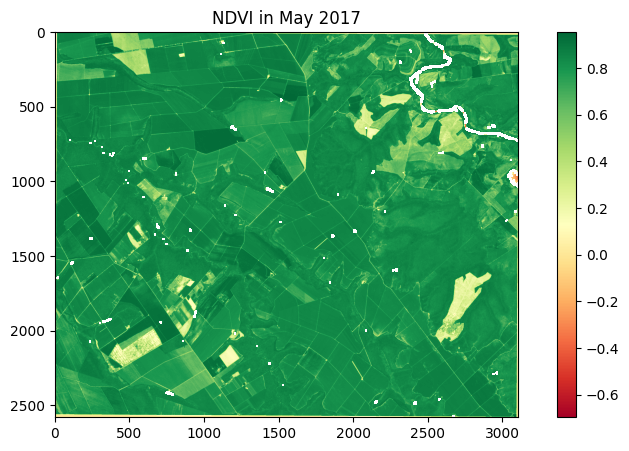

In [17]:
with rasterio.open(pathlib.Path(root, 'data', "S2A_21LXF_20170507_0_L2A", "ndvi.tiff"), 'r+') as ds1:
    ndvi1 = ds1.read(1)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title("NDVI in May 2017")
    im = ax.imshow(ndvi1, cmap='RdYlGn', vmin = np.nanmin(ndvi1), vmax = np.nanmax(ndvi1))
    fig.colorbar(im)
    plt.imshow(ndvi1, cmap='RdYlGn')

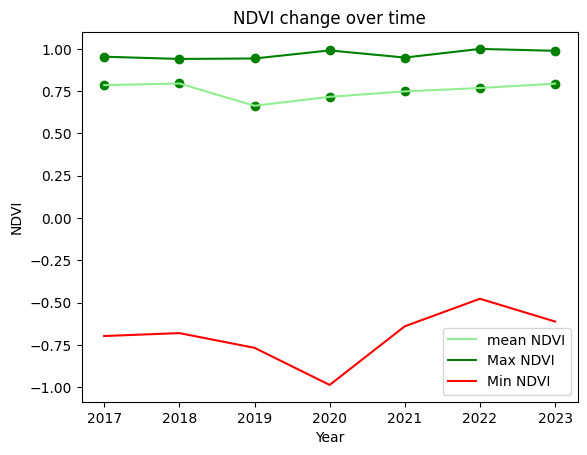

In [18]:
year = [2017, 2018, 2019, 2020, 2021, 2022, 2023]

plt.scatter(year, means, color='green')
plt.scatter(year, maxs, color='green')
plt.plot(year, means, color='lightgreen', label='mean NDVI')
plt.plot(year, maxs, color='green', label='Max NDVI')
plt.plot(year, mins, color='red', label='Min NDVI')
plt.xlabel('Year')
plt.ylabel('NDVI')
plt.title('NDVI change over time')
#plt.plot(year, mins, color='green', label='Max NDVI')
plt.legend()
plt.show()

In [19]:
#python reads directories in alphabetical order, so this sorts the folders by year to get the correct order:

data_folder = pathlib.Path(root, 'data')
folders = [f for f in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, f))]
#sort the folders in the order of the years they contain inside the string:
folders = sorted(folders, key=lambda x: x[10:14])

ndvi_variables = []
for folder in folders:
    with rasterio.open(pathlib.Path(root, 'data', folder, "ndvi.tiff")) as src:
        print(pathlib.Path(root, 'data', folder, "ndvi.tiff"))
        ndvi = src.read(1)
        ndvi_variables.append(ndvi)

/Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20170507_0_L2A/ndvi.tiff
/Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20180502_0_L2A/ndvi.tiff
/Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20190527_0_L2A/ndvi.tiff
/Users/jsmith/Desktop/Challenge/data/S2B_21LXF_20200526_1_L2A/ndvi.tiff
/Users/jsmith/Desktop/Challenge/data/S2B_21LXF_20210501_1_L2A/ndvi.tiff
/Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20220501_0_L2A/ndvi.tiff
/Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20230516_0_L2A/ndvi.tiff


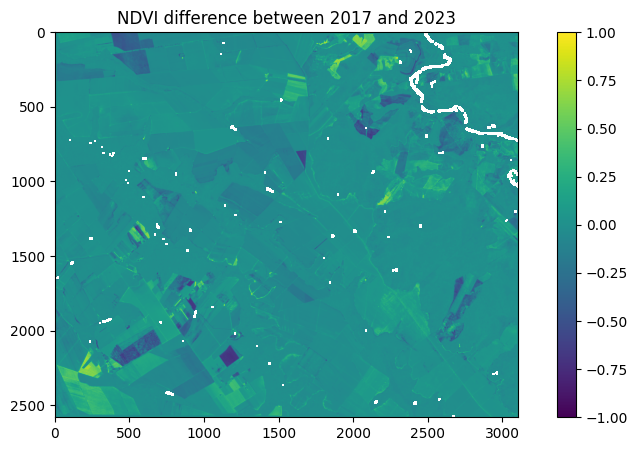

In [164]:
dif = (ndvi_variables[0] - ndvi_variables[6])
with rasterio.open(pathlib.Path(root, "ndvi_dif.tiff"), 'w', **ds1.meta) as dst:
    dst.write(dif, indexes=1)

cmap = 'viridis'
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("NDVI difference between 2017 and 2023")
im = ax.imshow(dif, cmap=cmap, vmin = -1, vmax = 1)
fig.colorbar(im)
plt.show()

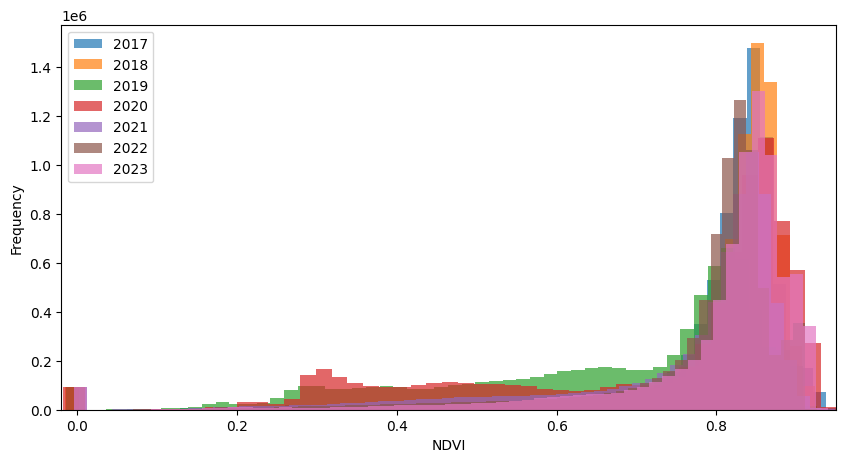

In [32]:
#show a histogram of the two events.
#This is a bit difficult to discern, but shifted distributions are evidence of change on the ground. 
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(ndvi_variables[0][~np.isnan(ndvi_variables[0])], bins=100, alpha = 0.7, label='2017')
ax.hist(ndvi_variables[1][~np.isnan(ndvi_variables[1])], bins=100, alpha = 0.7, label='2018')
ax.hist(ndvi_variables[2][~np.isnan(ndvi_variables[2])], bins=100, alpha = 0.7, label='2019')
ax.hist(ndvi_variables[3][~np.isnan(ndvi_variables[3])], bins=100, alpha = 0.7, label='2020')
ax.hist(ndvi_variables[4][~np.isnan(ndvi_variables[4])], bins=100, alpha = 0.7, label='2021')
ax.hist(ndvi_variables[5][~np.isnan(ndvi_variables[5])], bins=100, alpha = 0.7, label='2022')
ax.hist(ndvi_variables[6][~np.isnan(ndvi_variables[6])], bins=100, alpha = 0.7, label='2023')
plt.xlim(-0.02  , 0.95)
plt.legend(loc='upper left')
plt.xlabel('NDVI')
plt.ylabel('Frequency')
plt.show()

There was a net growth area of NDVI in the AOI of 315.426 km^2
As a percentage of the AOI area, this corresponds to  40.0 %


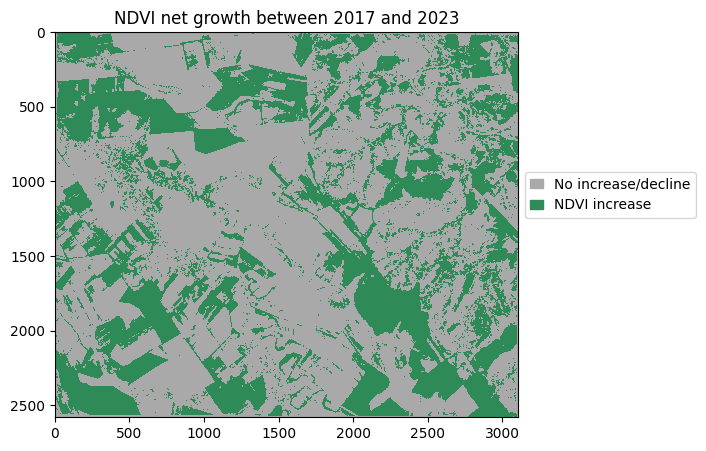

In [36]:
## reclassify the raster to show just positive and negative changes
## in this case, green is positive and black is negative (or null values due to cloud cover)

reclass = dif.copy()
reclass[np.where(reclass < 0 )] = 0
reclass[np.where(reclass > 0 )] = 1
reclass[np.isnan(reclass)] = 0

n_pix = np.count_nonzero(reclass == 1)
sqm = np.absolute(out_meta['transform'][0] * out_meta['transform'][4]) * n_pix
ndvi_growth_sqkm = sqm / 1000000

n_pix_tot = (out_meta['width'] * out_meta['height']) 
n_pix_sqkm = n_pix_tot * np.absolute(out_meta['transform'][0] * out_meta['transform'][4]) / 1000000

ndvi_growth_percent = ndvi_growth_sqkm / n_pix_sqkm
print("There was a net growth area of NDVI in the AOI of", ndvi_growth_sqkm , "km^2")
print("As a percentage of the AOI area, this corresponds to ", np.round(ndvi_growth_percent,1) * 100 , "%")

cmap = ListedColormap(['darkgrey', 'seagreen'])
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("NDVI net growth between 2017 and 2023")
im = ax.imshow(reclass, cmap=cmap, vmin = 0, vmax = 1)

class1 = mpatches.Patch(color='darkgrey', label='No increase/decline')
class2 = mpatches.Patch(color='seagreen', label='NDVI increase')

ax.legend(handles=[class1,class2],
          handlelength=0.9,bbox_to_anchor=(1, 0.5),loc='lower left')
plt.show()


# Conclusion

This was a very simple, quick analysis of NDVI at only 7 time steps. The AOI appears to be an area that had some forest felling activity, with parts increasing in NDVI in recent years. 

There is some suggestion that NDVI values may be increasing as time goes on, but a closer look is needed at overall annual trends. e.g. Taking a large number of NDVI images and plotting descriptive statistics over more years, across possibly another sensor. This method is more complex as NDVI will take on a sinusoidal relationship due to its being affected strongly by seasonality. More sophisticated time series tools would be needed to check if the difference in NDVI over time is statistically significant.

Here, I've shown some basic applications that that are made possible by calling STAC items using the UP42 SDK:
Green Plant Gmbh can check a sample NDVI output for their AOI, which allows for a quick check to see if any parcels of land are in a dire shape (low, or negative NDVI scores, suggesting deforestation).

By tracking images in May over a few years, we can see an overall trend to increasing NDVI from 2018 on. This relationship may be simply by chance alone, and further analysis is needed to confirm or deny. These differences could also be explained by better or worse climatic conditions that affect NDVI of the local vegetation. 

The difference raster shows areas in the AOI that have been most affected, and can inform in-situ investigations in the corresponding areas. The histogram suggests a trend is increasing. It is important to note that these are comparisons between two time steps only, and -again- more permutations would help ascertain if this trend is real. 



In [ ]:
#Final parts to do:
#- substract 2023 from 2017 and see the percent of decrease?

In [37]:
with rasterio.open(pathlib.Path(root, "ndvi_dif_reclass.tiff"), 'w', **ds1.meta) as dst:
    dst.write(reclass, indexes=1)

In [106]:
data_folder = pathlib.Path(root, 'data')
folders = [f for f in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, f))]
#sort the folders in the order of the years they contain inside the string:
folders = sorted(folders, key=lambda x: x[10:14])

ndvi_variables = []
for folder in folders:
    with rasterio.open(pathlib.Path(root, 'data', folder, "ndvi.tiff")) as src:
        print(pathlib.Path(root, 'data', folder, "ndvi.tiff"))
        ndvi = src.read(1)
        ndvi_variables.append(ndvi)

print(np.nanmean(ndvi_variables[0]))
print(np.nanmean(ndvi_variables[1]))
print(np.nanmean(ndvi_variables[2]))
print(np.nanmean(ndvi_variables[3]))
print(np.nanmean(ndvi_variables[4]))
print(np.nanmean(ndvi_variables[5]))
print(np.nanmean(ndvi_variables[6]))

/Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20170507_0_L2A/ndvi.tiff
/Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20180502_0_L2A/ndvi.tiff
/Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20190527_0_L2A/ndvi.tiff
/Users/jsmith/Desktop/Challenge/data/S2B_21LXF_20200526_1_L2A/ndvi.tiff
/Users/jsmith/Desktop/Challenge/data/S2B_21LXF_20210501_1_L2A/ndvi.tiff
/Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20220501_0_L2A/ndvi.tiff
/Users/jsmith/Desktop/Challenge/data/S2A_21LXF_20230516_0_L2A/ndvi.tiff
0.78524697
0.7950364
0.66343766
0.71629894
0.74842167
0.76831746
0.793885


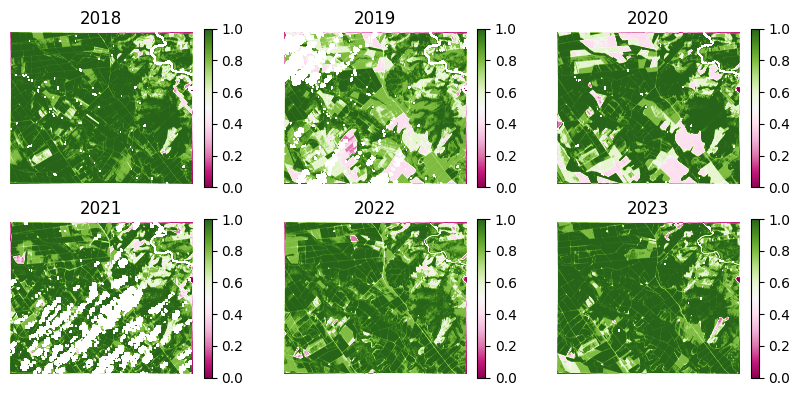

In [159]:
#Show a six plot panel of NDVI images reclassified to 4 classes:

# create figure 
fig = plt.figure(figsize=(10, 7)) 
  
# setting values to rows and column variables 
rows = 3
columns = 3
for i in range(1,7):
    classes = ndvi_variables[i].copy()
    classes[np.where( classes < 0 )] = 0.0
    classes[np.where((0.0 < classes) & (classes < 0.2)) ] = 0.2
    classes[np.where((0.2 < classes) & (classes < 0.4)) ] = 0.4
    classes[np.where((0.4 < classes) & (classes < 0.6)) ] = 0.6
    classes[np.where((0.6 < classes) & (classes < 0.8)) ] = 0.8
    classes[np.where(classes > 0.8 )] = 1.0

    fig.add_subplot(rows, columns, i) 
    im = plt.imshow(classes, cmap='PiYG', vmin = np.nanmin(classes), vmax = np.nanmax(classes))
    fig.colorbar(im)
    plt.axis('off') 
    plt.title(2017+i)